In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from functools import reduce
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from skimage.feature import hog
from lesson_functions import *
%matplotlib inline

In [2]:
# import the python debugger
import pdb

# Read in dataset

In [3]:
# Read in cars and notcars
use_small = False

# small dataset
if use_small:
    image_files = glob.glob('./training_data/smallset/*/*.jpeg')
    car_files = []
    notcar_files = []
    for fname in image_files:
        if 'image' in fname or 'extra' in fname:
            notcar_files.append(fname)
        else:
            car_files.append(fname)

    # reduce for quick tests
    sample_size = -1 # 500
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]

# read in full dataset
else:
    car_files = glob.glob('./training_data/fullset/vehicles/*/*.png')
    notcar_files = glob.glob('./training_data/fullset/non-vehicles/*/*.png')
    
    sample_size = -1 # 500
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]


# Set Feature Extraction Parameters

Run this module regardless if we're training a new, or loading pre-trained models.

In [4]:
#-------------------------------
# Feature Extraction Parameters
#-------------------------------

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# spatial binning dimensions
spatial = (32,32) # 32 seems optimal

# histogram binsdd
histbin = 32 # 32 seems pretty good

# HOG parameters
orient = 9 #9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

## IF...
## Training a New Model

In [5]:
#--------------------
# Feature extraction
#--------------------

t=time.time()
car_features = extract_features(car_files, color_space=colorspace,
                                spatial_size=spatial, hist_bins=histbin,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcar_files, color_space=colorspace,
                                   spatial_size=spatial, hist_bins=histbin,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print()

#------------------
# Setup X & y data
#   and Normalize
#------------------

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#------------------
# Train/Test split
#------------------

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Parameters:')
print(colorspace,'color spaces')
print(spatial[0],'spatial params,', histbin, 'histogram bins')
print('HOG: channels = ',hog_channel)
print(orient,'orientations',pix_per_cell,'pixels per cell and',
      cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print()

# Use a linear SVC 
svc = LinearSVC()

#-------------
# Train model
#-------------

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

145.4 Seconds to extract features...

Parameters:
YCrCb color spaces
32 spatial params, 32 histogram bins
HOG: channels =  ALL
9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460

10.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9952
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
0.00573 Seconds to predict 10 labels with SVC


Save off newly trained model into a pickle file

In [6]:
# save off model into pickle file
pickle_jar = {'svc': svc,
              'X_scaler': X_scaler,
              'orient': orient,
              'pix_per_cell': pix_per_cell,
              'cell_per_block': cell_per_block,
              'spatial': spatial,
              'histbin': histbin}
with open('saved_model.p', 'wb') as f:
    pickle.dump(pickle_jar, f)

## ELSE IF...
## Load Previously Trained Model

In [5]:
# alternately, load saved model
pickle_jar = pickle.load( open('saved_model_0.p', 'rb'))

svc            = pickle_jar['svc']
X_scaler       = pickle_jar['X_scaler']
orient         = pickle_jar['orient']
pix_per_cell   = pickle_jar['pix_per_cell']
cell_per_block = pickle_jar['cell_per_block']
spatial        = pickle_jar['spatial']
histbin        = pickle_jar['histbin']

### Predict on images
Now that we have (the important pieces):
- X_scaler (for normalizing the features)
- svc (the trained SVM Classifier)

Let's run it on some images...

In [6]:
from scipy.ndimage.measurements import label

Load test images

In [7]:
# img = mpimg.imread('./test_images/straight_lines2.jpg')
img = mpimg.imread('./test_images/test4.jpg')

From experimentation, looks like bounding box scaling at **[0.75, 1.0, 1.5, 2.0]** found decent results. We'll choose from out of these for the final algorithm. Most likely dropping some of the smaller values because of possible diminishing return on performance -vs- computational cost.

11 bounding boxes found, out of 912 searches at 1.0 scale level


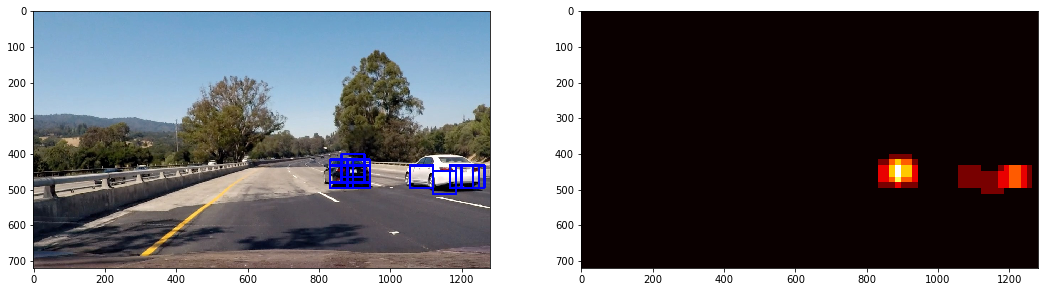

In [8]:
# Bound the vertical portion of the image for vehicle search
ystart = 400
ystop = 656

scale = 1.0

# this function implements a windowing search across specified region of the input image
bbox_list, out_img, n = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                  pix_per_cell, cell_per_block, spatial, histbin)

# create heatmap for this frame
threshold = 0
heatmap = np.clip(make_heatmap(img.shape[:2], bbox_list, threshold), 0, 127)

# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(img, labels)

plt.figure(figsize=(18,32*2))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

print(len(bbox_list),'bounding boxes found, out of',n,'searches at',scale,'scale level')

5 bounding boxes found, out of 144 searches at 2.0 scale level


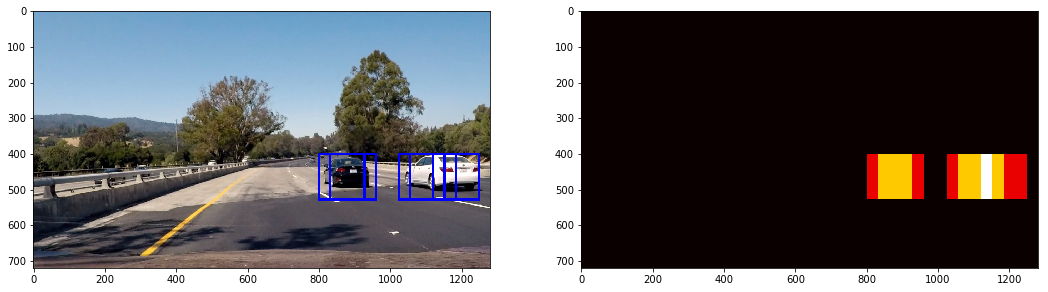

In [9]:
# Bound the vertical portion of the image for vehicle search
ystart = 400
ystop = 656

scale = 2.0

# this function implements a windowing search across specified region of the input image
bbox_list, out_img, n = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                  pix_per_cell, cell_per_block, spatial, histbin)

# create heatmap for this frame
threshold = 0
heatmap = np.clip(make_heatmap(img.shape[:2], bbox_list, threshold), 0, 127)

# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(img, labels)

plt.figure(figsize=(18,32*2))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

print(len(bbox_list),'bounding boxes found, out of',n,'searches at',scale,'scale level')

# Process on time-series of images

Setup a **[circular buffer](https://en.wikipedia.org/wiki/Circular_buffer)** to save past x-frames of heat map images

Will also add 'decaying' to the circular buffer, such that older stored values are reduced.

In [25]:
import collections

In [26]:
buffer_length = 10
heatmap_history = collections.deque(maxlen=buffer_length)

Note `'heatmap_history'` above is outside the `'find_vehicles()'` function below, thus is effectively a static variable that stays persistent over time / between calls.

## Setup pipeline function

In [31]:
def find_vehicles(img):
    scales = [1.0, 2.0]
#     scales = [0.75, 1.0, 1.5, 2.0] # orig planned scales to use
    threshold_static = 1
    threshold_dynamic = 0
    decay_rate = 1
    max_val = 255 # for uint8

    # init a new 'cold' heatmap
    heatmap = np.zeros(img.shape[:2]).astype(np.uint8)

    # loop thru all the search window sizes
    for scale in scales:
        bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                              cell_per_block, spatial, histbin, include_img=False)
        heatmap = add_heat(heatmap, bbox_list)

    heatmap = apply_threshold(heatmap, threshold_static)
    heatmap = np.clip(heatmap, 0, max_val) # max value of int8

    # decay the existing heatmap history, before adding latest heatmap
    for hm in heatmap_history:
        hm[hm>0] -= decay_rate
    heatmap_history.append(heatmap)

    heatmap_total = np.sum(heatmap_history, axis=0)

    # search for contiguous heat regions
    labels = label(heatmap_total) # labels is a tuple

    # draw final boxed image
    draw_img = draw_labeled_bboxes(img, labels)

    return draw_img

# Import video editing moduel

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
# from IPython.display import HTML
from moviepy import __version__
print(__version__)

0.2.2.13


Setup input and output file names

In [14]:
vid_input = 'project_video.mp4'
# vid_input = 'test_video.mp4'

vid_output = 'my_project_video.mp4'

clip1 = VideoFileClip(vid_input)

Process the video!

(this takes ~30 minutes)

In [30]:
# clear out the circular buffer
heatmap_history.clear()

vid1_clip = clip1.fl_image(find_vehicles) #NOTE: this function expects color images!!

%time vid1_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video my_project_video.mp4
[MoviePy] Writing video my_project_video.mp4


100%|█████████▉| 1260/1261 [33:10<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_project_video.mp4 

CPU times: user 32min 7s, sys: 58 s, total: 33min 5s
Wall time: 33min 11s
